
# Sex-biased tissues per perturbagen analysis- Cancer drugs
--------------------------------------------------------------------------------

Author: Belén Otero Carrasco

Last updated 19 March 2024


--------------------------------------------------------------------------------

In [1]:
import pkg_resources
# Print version of cmapPy being used in current conda environment 
pkg_resources.get_distribution("cmapPy").version

'4.0.1'

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame
from cmapPy.pandasGEXpress.parse import parse
from scipy.stats import hypergeom
from scipy.stats import fisher_exact
from tqdm import tqdm

C:\Users\Usuario\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


### Functions

In [3]:
def signatures_ids_perturbagen(drug):
    sig_pertu_ids = final_sig_original_filter["sig_id"][final_sig_original_filter["pert_iname"] == drug]
    print("number of samples treated with this perturbagen:")
    return sig_pertu_ids

In [4]:
def perturbagen_significant_genes(sig_pertu_ids,drug):
    perturbagen_genes_exp = parse("./Touchstone/GSE92742_Broad_LINCS_Level5_COMPZ.MODZ_n473647x12328.gctx", cid=sig_pertu_ids)
    df_perturbagen_genes_exp = perturbagen_genes_exp.data_df
    df_filter_significant = df_perturbagen_genes_exp[(df_perturbagen_genes_exp >2.0) | (df_perturbagen_genes_exp <-2.0)]
    df_bool_sign = df_filter_significant.notna()
    df_bool_sign["count"] = df_bool_sign.sum(axis=1)
    df_bool_sign = df_bool_sign.reset_index()
    df_gene_change = df_bool_sign[df_bool_sign["count"]> 0]
    df_gene_change_id = df_gene_change[["rid","count"]]
    df_gene_change_id["perturbagen_name"] = drug
    df_gene_change_id["Signature_id"] = sig_pertu_ids
    return df_gene_change_id 

In [5]:
def filter_by_tissue(tissue_type):
    data_gtex = pd.read_csv("signif.sbgenes.txt", sep="\t")
    filtered_df_tissue = data_gtex[data_gtex["tissue"] == tissue_type]
    return filtered_df_tissue

In [6]:
def filter_by_ids_and_tissue(tissue_type):
    data_total_genes_share = pd.read_csv("genes_hugo+ensembl.csv", sep=",")
    data_gtex_filter = data_gtex.merge(data_total_genes_share , on="gene")
    filtered_df_tissue_ids = data_gtex_filter[data_gtex_filter["tissue"] == tissue_type]
    return filtered_df_tissue_ids

In [33]:
def preprocesing_plot(dataframe,sig_cell_info):
  
    
    info_cell = sig_cell_info[["sig_id","Signature_id","cell_id","primary_site"]]
    info_cell = info_cell.drop_duplicates()
    clue_tiss_sig_gtex_ = dataframe.merge(info_tissue_cell, left_on=["Signature"],right_on=["sig_id"])
    clue_tiss_sig_gtex_['Significant'] = clue_tiss_sig_gtex_.apply(lambda row: 'No' if row['P-value'] > 0.05 else 'Yes', axis=1)
    
    return clue_tiss_sig_gtex_

In [36]:
def pivot_table_plot(df_general_plus_siggenes):
    
    clue_tiss_sig_gtex_pivot = df_general_plus_siggenes[["Signature_id","Tissue_type", "Heatmap_values"]]
    clue_tiss_sig_gtex_pivot = clue_tiss_sig_gtex_pivot.drop_duplicates()
    group_dis = clue_tiss_sig_gtex_pivot.pivot(index='Signature_id', columns='Tissue_type', values='Heatmap_values')
    
    return group_dis

In [37]:
def plot_heatmap(group_dis,drug):
    
    fig, ax = plt.subplots(figsize=(25, 25))
    ax = sns.heatmap(group_dis,linewidth=.5,cmap=["#FDEBD0","#82E0AA","#e65caa","#2EC7CE","#117A65","#910956","#175296"],vmin=1, vmax=7)
    colorbar = ax.collections[0].colorbar
    #colorbar.set_ticks([0, 1, 2])
    plt.title(f'Sex-biased tissues on {drug} application', fontsize = 20) # title with fontsize 20
    plt.xlabel('Tissues', fontsize = 12) # x-axis label with fontsize 15
    plt.ylabel('Signatures', fontsize = 12) # y-axis label with fontsize 15
    plt.tight_layout()
    plt.savefig(f"./images_sex-biased/heatmap_sig_tissue_{drug}.svg")
    # plt.show()
    return None 

In [ ]:
def plot_scatter(group_dis,drug):
    
    fig, ax = plt.subplots(figsize=(25, 25))
    ax = sns.heatmap(group_dis,linewidth=.5,cmap=["#FDEBD0","#82E0AA","#e65caa","#2EC7CE","#117A65","#910956","#175296"],vmin=1, vmax=7)
    colorbar = ax.collections[0].colorbar
    #colorbar.set_ticks([0, 1, 2])
    plt.title(f'Sex-biased tissues on {drug} application', fontsize = 20) # title with fontsize 20
    plt.xlabel('Tissues', fontsize = 12) # x-axis label with fontsize 15
    plt.ylabel('Signatures', fontsize = 12) # y-axis label with fontsize 15
    plt.tight_layout()
    plt.savefig(f"./images_sex-biased/heatmap_sig_tissue_{drug}.svg")
    # plt.show()
    return None 

### Signature information

In [8]:
## signatures unique per cell line by TAS and exemplar = 1 

In [5]:
sig_cell_info = pd.read_excel(("new_signame_tas_exemplar.xlsx"),engine='openpyxl')
sig_cell_info.head()

cell_id base_cell_id sample_type primary_site  \
0    A375         A375       tumor         skin   
1    A375         A375       tumor         skin   
2    A375         A375       tumor         skin   
3    A375         A375       tumor         skin   
4    A375         A375       tumor         skin   

                            tissue   abrev             subtype  \
0  Skin_Not_Sun_Exposed_Suprapubic  SKINNS  malignant melanoma   
1  Skin_Not_Sun_Exposed_Suprapubic  SKINNS  malignant melanoma   
2  Skin_Not_Sun_Exposed_Suprapubic  SKINNS  malignant melanoma   
3  Skin_Not_Sun_Exposed_Suprapubic  SKINNS  malignant melanoma   
4  Skin_Not_Sun_Exposed_Suprapubic  SKINNS  malignant melanoma   

                                     sig_id                        pert_iname  \
0  CPC018_A375_6H:BRD-K06817181-001-01-5:10  1,2,3,4,5,6-hexabromocyclohexane   
1  CPC017_A375_6H:BRD-K74430258-001-01-2:10               1,2-dichlorobenzene   
2  CPC010_A375_6H:BRD-K32795028-001-10-9:10                 1-benzylimidazole   
3  CPC018_A375_6H:BRD-A80928489-001-01-0:10                    1-monopalmitin   
4  CPC018_A375_6H:BRD-K31491153-001-01-2:10                 1-phenylbiguanide   

        tas  is_exemplar                                Signature_id  
0  0.282354            1  1,2,3,4,5,6-hexabromocyclohexane_A375_skin  
1  0.057646            1               1,2-dichlorobenzene_A375_skin  
2  0.221885            1                 1-benzylimidazole_A375_skin  
3  0.118443            1                    1-monopalmitin_A375_skin  
4  0.313940            1                 1-phenylbiguanide_A375_skin

In [6]:
sig_cell_info_filter_site = sig_cell_info[(sig_cell_info["primary_site"]!= "ovary")
               & (sig_cell_info["primary_site"]!= "endometrium") & (sig_cell_info["primary_site"]!= "prostate")]
## deja mama porque en los de GTEX y puede estar en hombres tambien

In [7]:
cancer_drugs = pd.read_csv("drugs_cancer_clue.csv", sep=",")

In [8]:
drugs_ids = cancer_drugs[["pert_iname"]].drop_duplicates()

In [9]:
drugs_ids = drugs_ids.values.ravel().tolist()

In [10]:
mapping_tissue_GTEX_CLUE = pd.read_excel(("mapping_tissues_GTEX_CLUE.xlsx"),engine='openpyxl')

#### Gene (row) annotations 

In [11]:
gene_info = pd.read_csv("./GSE92742_Broad_LINCS_gene_info.txt", sep="\t", dtype=str)
gene_info.columns

Index(['pr_gene_id', 'pr_gene_symbol', 'pr_gene_title', 'pr_is_lm',
       'pr_is_bing'],
      dtype='object')

In [12]:
pertub_id = pd.read_csv("./GSE92742_Broad_LINCS_pert_info.txt", sep="\t", dtype=str)

In [13]:
per_metrics_id = pd.read_csv("./GSE92742_Broad_LINCS_pert_metrics.txt", sep="\t", dtype=str)
per_metrics_id = per_metrics_id.replace({"-666":"Unknown"})

In [14]:
data_total_genes_share = pd.read_csv("genes_hugo+ensembl.csv", sep=",")

In [15]:
data_gtex = pd.read_csv("signif.sbgenes.txt", sep="\t")

In [16]:
data_gtex['Sex-bias'] = data_gtex.apply(lambda row: 'Female' if row['effsize'] >= 0 else 'Male', axis=1)

In [17]:
data_gtex_filter = data_gtex.merge(data_total_genes_share , on="gene")

In [18]:
pd.options.mode.chained_assignment = None 

In [19]:
data_gtex_tissues = data_gtex["tissue"].unique()

In [20]:
top30_top5 = pd.read_excel(("top_30_auto_top5_tissue.xlsx"),engine='openpyxl')
top30_top5.head()

Unnamed: 0     ENSEMBL_gene_id   HUGO_gene_id                  Tissue  \
0           0  ENSG00000165566.12          AMER2  Adipose - Subcutaneous   
1           1  ENSG00000185053.13           SGCZ  Adipose - Subcutaneous   
2           2  ENSG00000103449.11          SALL1  Adipose - Subcutaneous   
3           3   ENSG00000253967.1  RP11-333A23.4  Adipose - Subcutaneous   
4           4   ENSG00000258484.3         SPESP1  Adipose - Subcutaneous   

   Shapley_sum           Tissue_gtex  
0   274.341640  Adipose_Subcutaneous  
1   246.744640  Adipose_Subcutaneous  
2   113.793976  Adipose_Subcutaneous  
3   105.479940  Adipose_Subcutaneous  
4    89.989280  Adipose_Subcutaneous

In [22]:
data_gtex_top5 = data_gtex.merge(top30_top5 , left_on=["gene","tissue"], right_on = ["ENSEMBL_gene_id","Tissue_gtex"], how = "right")

In [23]:
data_gtex_top5

gene                tissue   effsize  effsize_se  \
0    ENSG00000165566.12  Adipose_Subcutaneous -3.720662    0.257654   
1    ENSG00000185053.13  Adipose_Subcutaneous -2.243292    0.189607   
2    ENSG00000103449.11  Adipose_Subcutaneous  1.085201    0.096319   
3     ENSG00000253967.1  Adipose_Subcutaneous -1.666114    0.209413   
4     ENSG00000258484.3  Adipose_Subcutaneous -0.780552    0.074077   
..                  ...                   ...       ...         ...   
215   ENSG00000205611.4           Whole_Blood -1.347224    0.105102   
216   ENSG00000253967.1           Whole_Blood -1.157027    0.164296   
217  ENSG00000022556.15           Whole_Blood  0.452990    0.054122   
218  ENSG00000149531.15           Whole_Blood -0.599008    0.045453   
219   ENSG00000237238.2           Whole_Blood  0.642073    0.108492   

             lfsr Sex-bias  Unnamed: 0     ENSEMBL_gene_id   HUGO_gene_id  \
0    1.110223e-16     Male           0  ENSG00000165566.12          AMER2   
1    0.000000e+00     Male           1  ENSG00000185053.13           SGCZ   
2    4.733551e-27   Female           2  ENSG00000103449.11          SALL1   
3    1.668665e-13     Male           3   ENSG00000253967.1  RP11-333A23.4   
4    0.000000e+00     Male           4   ENSG00000258484.3         SPESP1   
..            ...      ...         ...                 ...            ...   
215  0.000000e+00     Male        1278   ENSG00000205611.4      LINC01597   
216  9.159340e-13     Male        1279   ENSG00000253967.1  RP11-333A23.4   
217  1.500167e-18   Female        1280  ENSG00000022556.15          NLRP2   
218  1.110223e-16     Male        1281  ENSG00000149531.15         FRG1BP   
219  1.515213e-10   Female        1282   ENSG00000237238.2        BMS1P10   

                     Tissue  Shapley_sum           Tissue_gtex  
0    Adipose - Subcutaneous   274.341640  Adipose_Subcutaneous  
1    Adipose - Subcutaneous   246.744640  Adipose_Subcutaneous  
2    Adipose - Subcutaneous   113.793976  Adipose_Subcutaneous  
3    Adipose - Subcutaneous   105.479940  Adipose_Subcutaneous  
4    Adipose - Subcutaneous    89.989280  Adipose_Subcutaneous  
..                      ...          ...                   ...  
215             Whole Blood   138.051800           Whole_Blood  
216             Whole Blood   115.951890           Whole_Blood  
217             Whole Blood    75.203620           Whole_Blood  
218             Whole Blood    66.512640           Whole_Blood  
219             Whole Blood    46.464928           Whole_Blood  

[220 rows x 12 columns]

In [24]:
len(data_gtex_top5["HUGO_gene_id"].unique())

111

In [54]:
#drugs_ids_check = ["sirolimus"]

In [25]:
signatures_per_perturbagen = []
genes_significant_per_perturbagen = []
p_values_per_tissue_perturbagen = []
df = pd.DataFrame(columns=["Signature","Perturbagen_name", "P-value" ])
overlap_genes = []

for drug in tqdm(drugs_ids):
    print(drug)
    sig_pertu_ids = sig_cell_info_filter_site["sig_id"][sig_cell_info_filter_site["pert_iname"] == drug]
    sig_pertu_ids = sig_pertu_ids.drop_duplicates()
    print (len(sig_pertu_ids))
    signatures_per_perturbagen.append(sig_pertu_ids)
    
    for num_sig, sig in enumerate(sig_pertu_ids): 
        #print (num_sig, sig)
        genes_significant = perturbagen_significant_genes(sig,drug)
        gene_info = pd.read_csv("./GSE92742_Broad_LINCS_gene_info.txt", sep="\t", dtype=str)
        genes_sig_per_pertur = genes_significant.merge(gene_info, left_on="rid", right_on="pr_gene_id")
        genes_sig_per_pertur = genes_sig_per_pertur[["perturbagen_name","Signature_id","pr_gene_id","pr_gene_symbol"]]
        genes_significant_per_perturbagen.append(genes_sig_per_pertur)

        
        overlap = genes_sig_per_pertur.merge(data_gtex_top5,left_on= "pr_gene_symbol",right_on="HUGO_gene_id")
        overlap = overlap[["perturbagen_name","Signature_id","HUGO_gene_id","Sex-bias"]]
        overlap_genes.append(overlap)
        df_all = pd.concat(overlap_genes)

        # parameters
        population_total = 20000 
        num_genes_change_expression_perturbagen = len(genes_sig_per_pertur)  # Number of genes clue significant
        num_genes_escap = len(data_gtex_top5) # GTEX tissue type n-genes
        overlap_len = len(overlap)  #overlap
        #test 
        #resultado = hypergeom.sf(overlap - 1, population_total, num_genes_change_expression_perturbagen, num_genes_gtex_tissue)
        result = hypergeom.sf(overlap_len - 1, population_total,num_genes_escap,num_genes_change_expression_perturbagen)
        p_values_per_tissue_perturbagen.append(result)
        #print("P-value:", resultado, tissue, drug)
        row = pd.DataFrame({"P-value": [result], "Perturbagen_name": [drug],"Signature":[sig]})
        df = pd.concat([df, row])
        
    

    
    

  0%|                                                                                           | 0/95 [00:00<?, ?it/s]

idarubicin
37


  1%|▊                                                                                  | 1/95 [00:15<24:41, 15.76s/it]

rucaparib
38


  2%|█▋                                                                                 | 2/95 [00:31<24:29, 15.80s/it]

afatinib
15


  3%|██▌                                                                                | 3/95 [00:38<19:52, 12.97s/it]

celecoxib
13


  4%|███▍                                                                               | 4/95 [00:43<16:15, 10.72s/it]

exemestane
11


  5%|████▎                                                                              | 5/95 [00:48<13:23,  8.92s/it]

mercaptopurine
5


  6%|█████▏                                                                             | 6/95 [00:50<10:14,  6.90s/it]

cyclophosphamide
6


  7%|██████                                                                             | 7/95 [00:52<08:13,  5.60s/it]

decitabine
12


  8%|██████▉                                                                            | 8/95 [00:58<07:57,  5.49s/it]

temsirolimus
38


  9%|███████▊                                                                           | 9/95 [01:14<12:29,  8.72s/it]

goserelin
7


 11%|████████▋                                                                         | 10/95 [01:17<09:57,  7.03s/it]

vemurafenib
48


 12%|█████████▍                                                                        | 11/95 [01:38<15:52, 11.34s/it]

pirfenidone
11


 13%|██████████▎                                                                       | 12/95 [01:43<13:02,  9.43s/it]

nilutamide
11


 14%|███████████▏                                                                      | 13/95 [01:48<11:01,  8.07s/it]

tivozanib
43


 15%|████████████                                                                      | 14/95 [02:08<15:26, 11.44s/it]

axitinib
11


 16%|████████████▉                                                                     | 15/95 [02:13<12:41,  9.52s/it]

procarbazine
11


 17%|█████████████▊                                                                    | 16/95 [02:18<10:44,  8.16s/it]

formestane
11


 18%|██████████████▋                                                                   | 17/95 [02:23<09:25,  7.25s/it]

sorafenib
18


 19%|███████████████▌                                                                  | 18/95 [02:31<09:41,  7.55s/it]

fulvestrant
12


 20%|████████████████▍                                                                 | 19/95 [02:36<08:45,  6.91s/it]

anastrozole
7


 21%|█████████████████▎                                                                | 20/95 [02:40<07:14,  5.79s/it]

dasatinib
15


 22%|██████████████████▏                                                               | 21/95 [02:46<07:31,  6.10s/it]

letrozole
5


 23%|██████████████████▉                                                               | 22/95 [02:49<06:02,  4.96s/it]

altretamine
11


 24%|███████████████████▊                                                              | 23/95 [02:54<05:57,  4.97s/it]

azacitidine
6


 25%|████████████████████▋                                                             | 24/95 [02:56<05:04,  4.29s/it]

azathioprine
5


 26%|█████████████████████▌                                                            | 25/95 [02:59<04:18,  3.70s/it]

dactinomycin
10


 27%|██████████████████████▍                                                           | 26/95 [03:03<04:36,  4.01s/it]

vinblastine
13


 28%|███████████████████████▎                                                          | 27/95 [03:10<05:16,  4.65s/it]

cladribine
7


 29%|████████████████████████▏                                                         | 28/95 [03:13<04:45,  4.27s/it]

toremifene
11


 31%|█████████████████████████                                                         | 29/95 [03:18<05:05,  4.64s/it]

mitotane
11


 32%|█████████████████████████▉                                                        | 30/95 [03:24<05:12,  4.81s/it]

clofarabine
11


 33%|██████████████████████████▊                                                       | 31/95 [03:29<05:17,  4.96s/it]

capecitabine
11


 34%|███████████████████████████▌                                                      | 32/95 [03:34<05:19,  5.07s/it]

daunorubicin
17


 35%|████████████████████████████▍                                                     | 33/95 [03:42<06:09,  5.96s/it]

ruxolitinib
17


 36%|█████████████████████████████▎                                                    | 34/95 [03:50<06:40,  6.57s/it]

neratinib
44


 37%|██████████████████████████████▏                                                   | 35/95 [04:12<10:59, 11.00s/it]

palbociclib
17


 38%|███████████████████████████████                                                   | 36/95 [04:20<09:59, 10.17s/it]

everolimus
12


 39%|███████████████████████████████▉                                                  | 37/95 [04:26<08:37,  8.93s/it]

tegafur
5


 40%|████████████████████████████████▊                                                 | 38/95 [04:29<06:40,  7.03s/it]

sonidegib
38


 41%|█████████████████████████████████▋                                                | 39/95 [04:48<09:55, 10.63s/it]

ixazomib
40


 42%|██████████████████████████████████▌                                               | 40/95 [05:07<12:02, 13.13s/it]

tofacitinib
11


 43%|███████████████████████████████████▍                                              | 41/95 [05:12<09:41, 10.76s/it]

raltitrexed
11


 44%|████████████████████████████████████▎                                             | 42/95 [05:18<08:18,  9.41s/it]

vindesine
4


 45%|█████████████████████████████████████                                             | 43/95 [05:20<06:18,  7.29s/it]

abiraterone
6


 46%|█████████████████████████████████████▉                                            | 44/95 [05:24<05:11,  6.11s/it]

nilotinib
17


 47%|██████████████████████████████████████▊                                           | 45/95 [05:32<05:41,  6.83s/it]

tacrolimus
42


 48%|███████████████████████████████████████▋                                          | 46/95 [05:55<09:33, 11.70s/it]

bosutinib
13


 49%|████████████████████████████████████████▌                                         | 47/95 [06:03<08:18, 10.38s/it]

methotrexate
6


 51%|█████████████████████████████████████████▍                                        | 48/95 [06:06<06:25,  8.21s/it]

docetaxel
9


 52%|██████████████████████████████████████████▎                                       | 49/95 [06:10<05:27,  7.13s/it]

tretinoin
46


 53%|███████████████████████████████████████████▏                                      | 50/95 [06:34<09:01, 12.04s/it]

belinostat
11


 54%|████████████████████████████████████████████                                      | 51/95 [06:40<07:29, 10.21s/it]

bicalutamide
11


 55%|████████████████████████████████████████████▉                                     | 52/95 [06:46<06:22,  8.90s/it]

diethylstilbestrol
11


 56%|█████████████████████████████████████████████▋                                    | 53/95 [06:52<05:43,  8.18s/it]

sirolimus
49


 57%|██████████████████████████████████████████████▌                                   | 54/95 [07:18<09:12, 13.47s/it]

epirubicin
13


 58%|███████████████████████████████████████████████▍                                  | 55/95 [07:25<07:44, 11.62s/it]

paclitaxel
14


 59%|████████████████████████████████████████████████▎                                 | 56/95 [07:33<06:42, 10.31s/it]

amsacrine
11


 60%|█████████████████████████████████████████████████▏                                | 57/95 [07:38<05:36,  8.86s/it]

etoposide
8


 61%|██████████████████████████████████████████████████                                | 58/95 [07:42<04:35,  7.44s/it]

teniposide
42


 62%|██████████████████████████████████████████████████▉                               | 59/95 [08:04<07:03, 11.76s/it]

thalidomide
44


 63%|███████████████████████████████████████████████████▊                              | 60/95 [08:26<08:42, 14.93s/it]

pazopanib
17


 64%|████████████████████████████████████████████████████▋                             | 61/95 [08:40<08:19, 14.69s/it]

irinotecan
11


 65%|█████████████████████████████████████████████████████▌                            | 62/95 [09:00<08:52, 16.13s/it]

panobinostat
13


 66%|██████████████████████████████████████████████████████▍                           | 63/95 [09:22<09:36, 18.03s/it]

aminoglutethimide
11


 67%|███████████████████████████████████████████████████████▏                          | 64/95 [09:42<09:35, 18.55s/it]

chlorambucil
11


 68%|████████████████████████████████████████████████████████                          | 65/95 [10:01<09:20, 18.68s/it]

olaparib
38


 69%|████████████████████████████████████████████████████████▉                         | 66/95 [11:08<16:01, 33.15s/it]

doxorubicin
10


 71%|█████████████████████████████████████████████████████████▊                        | 67/95 [11:25<13:08, 28.16s/it]

sunitinib
12


 72%|██████████████████████████████████████████████████████████▋                       | 68/95 [11:45<11:37, 25.82s/it]

erlotinib
17


 73%|███████████████████████████████████████████████████████████▌                      | 69/95 [12:16<11:50, 27.34s/it]

vinorelbine
12


 74%|████████████████████████████████████████████████████████████▍                     | 70/95 [12:36<10:33, 25.33s/it]

lapatinib
16


 75%|█████████████████████████████████████████████████████████████▎                    | 71/95 [13:03<10:18, 25.78s/it]

mitoxantrone
8


 76%|██████████████████████████████████████████████████████████████▏                   | 72/95 [13:15<08:18, 21.67s/it]

crizotinib
17


 77%|███████████████████████████████████████████████████████████████                   | 73/95 [13:24<06:33, 17.87s/it]

midostaurin
11


 78%|███████████████████████████████████████████████████████████████▊                  | 74/95 [13:30<05:00, 14.30s/it]

thiotepa
11


 79%|████████████████████████████████████████████████████████████████▋                 | 75/95 [13:36<03:55, 11.78s/it]

alitretinoin
13


 80%|█████████████████████████████████████████████████████████████████▌                | 76/95 [13:43<03:17, 10.41s/it]

anagrelide
11


 81%|██████████████████████████████████████████████████████████████████▍               | 77/95 [13:50<02:44,  9.15s/it]

cytarabine
8


 82%|███████████████████████████████████████████████████████████████████▎              | 78/95 [13:54<02:12,  7.80s/it]

flutamide
43


 83%|████████████████████████████████████████████████████████████████████▏             | 79/95 [14:19<03:25, 12.84s/it]

temozolomide
41


 84%|█████████████████████████████████████████████████████████████████████             | 80/95 [14:42<03:58, 15.93s/it]

busulfan
6


 85%|█████████████████████████████████████████████████████████████████████▉            | 81/95 [14:46<02:50, 12.20s/it]

tamoxifen
45


 86%|██████████████████████████████████████████████████████████████████████▊           | 82/95 [15:11<03:28, 16.08s/it]

topotecan
11


 87%|███████████████████████████████████████████████████████████████████████▋          | 83/95 [15:17<02:37, 13.10s/it]

lenalidomide
43


 88%|████████████████████████████████████████████████████████████████████████▌         | 84/95 [15:41<03:00, 16.45s/it]

gemcitabine
35


 89%|█████████████████████████████████████████████████████████████████████████▎        | 85/95 [16:01<02:56, 17.63s/it]

vincristine
10


 91%|██████████████████████████████████████████████████████████████████████████▏       | 86/95 [16:07<02:06, 14.11s/it]

floxuridine
10


 92%|███████████████████████████████████████████████████████████████████████████       | 87/95 [16:13<01:32, 11.58s/it]

gefitinib
17


 93%|███████████████████████████████████████████████████████████████████████████▉      | 88/95 [16:23<01:16, 10.97s/it]

imatinib
17


 94%|████████████████████████████████████████████████████████████████████████████▊     | 89/95 [16:32<01:03, 10.59s/it]

leflunomide
11


 95%|█████████████████████████████████████████████████████████████████████████████▋    | 90/95 [16:39<00:46,  9.33s/it]

vorinostat
48


 96%|██████████████████████████████████████████████████████████████████████████████▌   | 91/95 [17:09<01:02, 15.57s/it]

streptozotocin
6


 97%|███████████████████████████████████████████████████████████████████████████████▍  | 92/95 [17:13<00:36, 12.10s/it]

homoharringtonine
11


 98%|████████████████████████████████████████████████████████████████████████████████▎ | 93/95 [17:20<00:21, 10.59s/it]

5-aminolevulinic-acid
6


 99%|█████████████████████████████████████████████████████████████████████████████████▏| 94/95 [17:24<00:08,  8.75s/it]

medroxyprogesterone
6


100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [17:29<00:00, 11.04s/it]


In [26]:
df

Signature     Perturbagen_name   P-value
0     CPC011_A375_6H:BRD-K69650333-003-11-6:10           idarubicin  0.998693
0     CPC011_A549_6H:BRD-K69650333-003-11-6:10           idarubicin  0.999996
0   CPC006_A673_6H:BRD-A71390734-001-01-7:0.08           idarubicin  1.000000
0    CPC006_AGS_6H:BRD-A71390734-001-01-7:0.08           idarubicin  1.000000
0   CPC006_CL34_6H:BRD-A71390734-001-01-7:0.08           idarubicin  1.000000
..                                         ...                  ...       ...
0     CPC020_A549_6H:BRD-K82216340-001-19-7:10  medroxyprogesterone  1.000000
0     CPC020_HA1E_6H:BRD-K82216340-001-19-7:10  medroxyprogesterone  1.000000
0   CPC020_HCC515_6H:BRD-K82216340-001-19-7:10  medroxyprogesterone  1.000000
0     CPC020_HT29_6H:BRD-K82216340-001-19-7:10  medroxyprogesterone  1.000000
0     CPC020_MCF7_6H:BRD-K82216340-001-19-7:10  medroxyprogesterone  1.000000

[1663 rows x 3 columns]

In [27]:
df_all

perturbagen_name                                Signature_id  \
0              idarubicin    CPC011_A375_6H:BRD-K69650333-003-11-6:10   
1              idarubicin    CPC011_A375_6H:BRD-K69650333-003-11-6:10   
0              idarubicin    CPC011_A549_6H:BRD-K69650333-003-11-6:10   
1              idarubicin    CPC011_A549_6H:BRD-K69650333-003-11-6:10   
2              idarubicin    CPC011_A549_6H:BRD-K69650333-003-11-6:10   
..                    ...                                         ...   
2   5-aminolevulinic-acid  CPC020_HCC515_6H:BRD-K57631554-001-07-4:10   
3   5-aminolevulinic-acid  CPC020_HCC515_6H:BRD-K57631554-001-07-4:10   
4   5-aminolevulinic-acid  CPC020_HCC515_6H:BRD-K57631554-001-07-4:10   
5   5-aminolevulinic-acid  CPC020_HCC515_6H:BRD-K57631554-001-07-4:10   
6   5-aminolevulinic-acid  CPC020_HCC515_6H:BRD-K57631554-001-07-4:10   

   HUGO_gene_id Sex-bias  
0         WISP2     Male  
1        PPFIA3   Female  
0         SALL1   Female  
1         SALL1   Female  
2         SALL1   Female  
..          ...      ...  
2         WISP2     Male  
3           SHH   Female  
4         ACKR1      NaN  
5         CDH20     Male  
6         NLRP2   Female  

[3469 rows x 4 columns]

In [28]:
info_cell = sig_cell_info[["sig_id","Signature_id","cell_id"]]
info_cell = info_cell.drop_duplicates()

In [29]:
info_cell

sig_id  \
0       CPC018_A375_6H:BRD-K06817181-001-01-5:10   
1       CPC017_A375_6H:BRD-K74430258-001-01-2:10   
2       CPC010_A375_6H:BRD-K32795028-001-10-9:10   
3       CPC018_A375_6H:BRD-A80928489-001-01-0:10   
4       CPC018_A375_6H:BRD-K31491153-001-01-2:10   
...                                          ...   
258599        KDB008_SKL_96H:TRCN0000020197:-666   
258600        KDB002_SKL_96H:TRCN0000236645:-666   
258601        KDB001_SKL_96H:TRCN0000150938:-666   
258602        KDB007_SKL_96H:TRCN0000072242:-666   
258603        KDB008_SKL_96H:TRCN0000145620:-666   

                                      Signature_id cell_id  
0       1,2,3,4,5,6-hexabromocyclohexane_A375_skin    A375  
1                    1,2-dichlorobenzene_A375_skin    A375  
2                      1-benzylimidazole_A375_skin    A375  
3                         1-monopalmitin_A375_skin    A375  
4                      1-phenylbiguanide_A375_skin    A375  
...                                            ...     ...  
258599                           ZNF589_SKL_muscle     SKL  
258600                           ZNF629_SKL_muscle     SKL  
258601                             ZW10_SKL_muscle     SKL  
258602                             lacZ_SKL_muscle     SKL  
258603                              pgw_SKL_muscle     SKL  

[173142 rows x 3 columns]

In [30]:
clue_tiss_sig_gtex_ = df.merge(info_cell, left_on=["Signature"],right_on=["sig_id"])
clue_tiss_sig_gtex_['Significant'] = clue_tiss_sig_gtex_.apply(lambda row: 'No' if row['P-value'] > 0.05 else 'Yes', axis=1)

In [31]:
clue_tiss_sig_gtex_

Signature     Perturbagen_name  \
0       CPC011_A375_6H:BRD-K69650333-003-11-6:10           idarubicin   
1       CPC011_A549_6H:BRD-K69650333-003-11-6:10           idarubicin   
2     CPC006_A673_6H:BRD-A71390734-001-01-7:0.08           idarubicin   
3      CPC006_AGS_6H:BRD-A71390734-001-01-7:0.08           idarubicin   
4     CPC006_CL34_6H:BRD-A71390734-001-01-7:0.08           idarubicin   
...                                          ...                  ...   
1658    CPC020_A549_6H:BRD-K82216340-001-19-7:10  medroxyprogesterone   
1659    CPC020_HA1E_6H:BRD-K82216340-001-19-7:10  medroxyprogesterone   
1660  CPC020_HCC515_6H:BRD-K82216340-001-19-7:10  medroxyprogesterone   
1661    CPC020_HT29_6H:BRD-K82216340-001-19-7:10  medroxyprogesterone   
1662    CPC020_MCF7_6H:BRD-K82216340-001-19-7:10  medroxyprogesterone   

       P-value                                      sig_id  \
0     0.998693    CPC011_A375_6H:BRD-K69650333-003-11-6:10   
1     0.999996    CPC011_A549_6H:BRD-K69650333-003-11-6:10   
2     1.000000  CPC006_A673_6H:BRD-A71390734-001-01-7:0.08   
3     1.000000   CPC006_AGS_6H:BRD-A71390734-001-01-7:0.08   
4     1.000000  CPC006_CL34_6H:BRD-A71390734-001-01-7:0.08   
...        ...                                         ...   
1658  1.000000    CPC020_A549_6H:BRD-K82216340-001-19-7:10   
1659  1.000000    CPC020_HA1E_6H:BRD-K82216340-001-19-7:10   
1660  1.000000  CPC020_HCC515_6H:BRD-K82216340-001-19-7:10   
1661  1.000000    CPC020_HT29_6H:BRD-K82216340-001-19-7:10   
1662  1.000000    CPC020_MCF7_6H:BRD-K82216340-001-19-7:10   

                                  Signature_id cell_id Significant  
0                         idarubicin_A375_skin    A375          No  
1                         idarubicin_A549_lung    A549          No  
2                         idarubicin_A673_bone    A673          No  
3                       idarubicin_AGS_stomach     AGS          No  
4              idarubicin_CL34_large intestine    CL34          No  
...                                        ...     ...         ...  
1658             medroxyprogesterone_A549_lung    A549          No  
1659           medroxyprogesterone_HA1E_kidney    HA1E          No  
1660           medroxyprogesterone_HCC515_lung  HCC515          No  
1661  medroxyprogesterone_HT29_large intestine    HT29          No  
1662           medroxyprogesterone_MCF7_breast    MCF7          No  

[1663 rows x 7 columns]

In [32]:
data_sig = clue_tiss_sig_gtex_[clue_tiss_sig_gtex_["Significant"]=="Yes"]   

In [33]:
data_sig

Signature Perturbagen_name  \
128    CPC013_HCC515_6H:BRD-K79254416-001-08-5:10       decitabine   
386      CPC020_A549_6H:BRD-K67043667-001-21-5:10      altretamine   
614   CPC006_NCIH596_6H:BRD-K19796430-001-01-5:10        sonidegib   
726    CPC006_DV90_6H:BRD-K08845546-001-02-2:22.2       tacrolimus   
885      CPC006_LOVO_6H:BRD-A79768653-001-02-1:10        sirolimus   
976     CPC016_HEPG2_6H:BRD-A35588707-001-03-0:10       teniposide   
1386     CPD001_MCF7_6H:BRD-K23204545-001-09-9:10         busulfan   
1508  CPC006_SKLU1_6H:BRD-K15108141-001-01-7:0.08      gemcitabine   

           P-value                                       sig_id  \
128   1.412917e-02   CPC013_HCC515_6H:BRD-K79254416-001-08-5:10   
386   5.242388e-04     CPC020_A549_6H:BRD-K67043667-001-21-5:10   
614   2.426766e-03  CPC006_NCIH596_6H:BRD-K19796430-001-01-5:10   
726   1.826632e-08   CPC006_DV90_6H:BRD-K08845546-001-02-2:22.2   
885   1.429427e-06     CPC006_LOVO_6H:BRD-A79768653-001-02-1:10   
976   3.108834e-03    CPC016_HEPG2_6H:BRD-A35588707-001-03-0:10   
1386  3.604655e-10     CPD001_MCF7_6H:BRD-K23204545-001-09-9:10   
1508  1.760271e-03  CPC006_SKLU1_6H:BRD-K15108141-001-01-7:0.08   

                        Signature_id  cell_id Significant  
128           decitabine_HCC515_lung   HCC515         Yes  
386            altretamine_A549_lung     A549         Yes  
614           sonidegib_NCIH596_lung  NCIH596         Yes  
726             tacrolimus_DV90_lung     DV90         Yes  
885   sirolimus_LOVO_large intestine     LOVO         Yes  
976           teniposide_HEPG2_liver    HEPG2         Yes  
1386            busulfan_MCF7_breast     MCF7         Yes  
1508          gemcitabine_SKLU1_lung    SKLU1         Yes

In [34]:
df_genes_tiss_sb = data_sig.merge(df_all, left_on= ["sig_id","Perturbagen_name"], right_on=["Signature_id","perturbagen_name"], how ="inner")

In [35]:
df_genes_tiss_sb

Signature Perturbagen_name   P-value  \
0    CPC013_HCC515_6H:BRD-K79254416-001-08-5:10       decitabine  0.014129   
1    CPC013_HCC515_6H:BRD-K79254416-001-08-5:10       decitabine  0.014129   
2    CPC013_HCC515_6H:BRD-K79254416-001-08-5:10       decitabine  0.014129   
3    CPC013_HCC515_6H:BRD-K79254416-001-08-5:10       decitabine  0.014129   
4    CPC013_HCC515_6H:BRD-K79254416-001-08-5:10       decitabine  0.014129   
..                                          ...              ...       ...   
88  CPC006_SKLU1_6H:BRD-K15108141-001-01-7:0.08      gemcitabine  0.001760   
89  CPC006_SKLU1_6H:BRD-K15108141-001-01-7:0.08      gemcitabine  0.001760   
90  CPC006_SKLU1_6H:BRD-K15108141-001-01-7:0.08      gemcitabine  0.001760   
91  CPC006_SKLU1_6H:BRD-K15108141-001-01-7:0.08      gemcitabine  0.001760   
92  CPC006_SKLU1_6H:BRD-K15108141-001-01-7:0.08      gemcitabine  0.001760   

                                         sig_id          Signature_id_x  \
0    CPC013_HCC515_6H:BRD-K79254416-001-08-5:10  decitabine_HCC515_lung   
1    CPC013_HCC515_6H:BRD-K79254416-001-08-5:10  decitabine_HCC515_lung   
2    CPC013_HCC515_6H:BRD-K79254416-001-08-5:10  decitabine_HCC515_lung   
3    CPC013_HCC515_6H:BRD-K79254416-001-08-5:10  decitabine_HCC515_lung   
4    CPC013_HCC515_6H:BRD-K79254416-001-08-5:10  decitabine_HCC515_lung   
..                                          ...                     ...   
88  CPC006_SKLU1_6H:BRD-K15108141-001-01-7:0.08  gemcitabine_SKLU1_lung   
89  CPC006_SKLU1_6H:BRD-K15108141-001-01-7:0.08  gemcitabine_SKLU1_lung   
90  CPC006_SKLU1_6H:BRD-K15108141-001-01-7:0.08  gemcitabine_SKLU1_lung   
91  CPC006_SKLU1_6H:BRD-K15108141-001-01-7:0.08  gemcitabine_SKLU1_lung   
92  CPC006_SKLU1_6H:BRD-K15108141-001-01-7:0.08  gemcitabine_SKLU1_lung   

   cell_id Significant perturbagen_name  \
0   HCC515         Yes       decitabine   
1   HCC515         Yes       decitabine   
2   HCC515         Yes       decitabine   
3   HCC515         Yes       decitabine   
4   HCC515         Yes       decitabine   
..     ...         ...              ...   
88   SKLU1         Yes      gemcitabine   
89   SKLU1         Yes      gemcitabine   
90   SKLU1         Yes      gemcitabine   
91   SKLU1         Yes      gemcitabine   
92   SKLU1         Yes      gemcitabine   

                                 Signature_id_y HUGO_gene_id Sex-bias  
0    CPC013_HCC515_6H:BRD-K79254416-001-08-5:10      HSD11B1     Male  
1    CPC013_HCC515_6H:BRD-K79254416-001-08-5:10        SALL1   Female  
2    CPC013_HCC515_6H:BRD-K79254416-001-08-5:10        SALL1   Female  
3    CPC013_HCC515_6H:BRD-K79254416-001-08-5:10        SALL1   Female  
4    CPC013_HCC515_6H:BRD-K79254416-001-08-5:10       HOXD11      NaN  
..                                          ...          ...      ...  
88  CPC006_SKLU1_6H:BRD-K15108141-001-01-7:0.08        DDX43     Male  
89  CPC006_SKLU1_6H:BRD-K15108141-001-01-7:0.08        DDX43     Male  
90  CPC006_SKLU1_6H:BRD-K15108141-001-01-7:0.08        DDX43     Male  
91  CPC006_SKLU1_6H:BRD-K15108141-001-01-7:0.08        DDX43     Male  
92  CPC006_SKLU1_6H:BRD-K15108141-001-01-7:0.08        DDX43     Male  

[93 rows x 11 columns]

In [40]:
df_genes_tiss_sb = df_genes_tiss_sb.fillna(1)

In [41]:
df_genes_tiss_sb_fil = df_genes_tiss_sb[["Signature_id_x","Sex-bias"]]

In [43]:
# Agrupar por ID y obtener la categoría con el mayor conteo para cada ID
max_category_by_id = df_genes_tiss_sb_fil.groupby('Signature_id_x')['Sex-bias'].apply(lambda x: x.value_counts().idxmax())

# Convertir la serie resultante en un DataFrame
result_df = max_category_by_id.reset_index(name='Sex-bias')

In [44]:
result_df

Signature_id_x Sex-bias
0           altretamine_A549_lung     Male
1            busulfan_MCF7_breast     Male
2          decitabine_HCC515_lung   Female
3          gemcitabine_SKLU1_lung     Male
4  sirolimus_LOVO_large intestine     Male
5          sonidegib_NCIH596_lung     Male
6            tacrolimus_DV90_lung     Male
7          teniposide_HEPG2_liver     Male

In [53]:
result_df.loc[result_df["Sex-bias"] == "Male", 'Gene-bias'] = 2
result_df.loc[result_df["Sex-bias"] == "Female", 'Gene-bias'] = 3

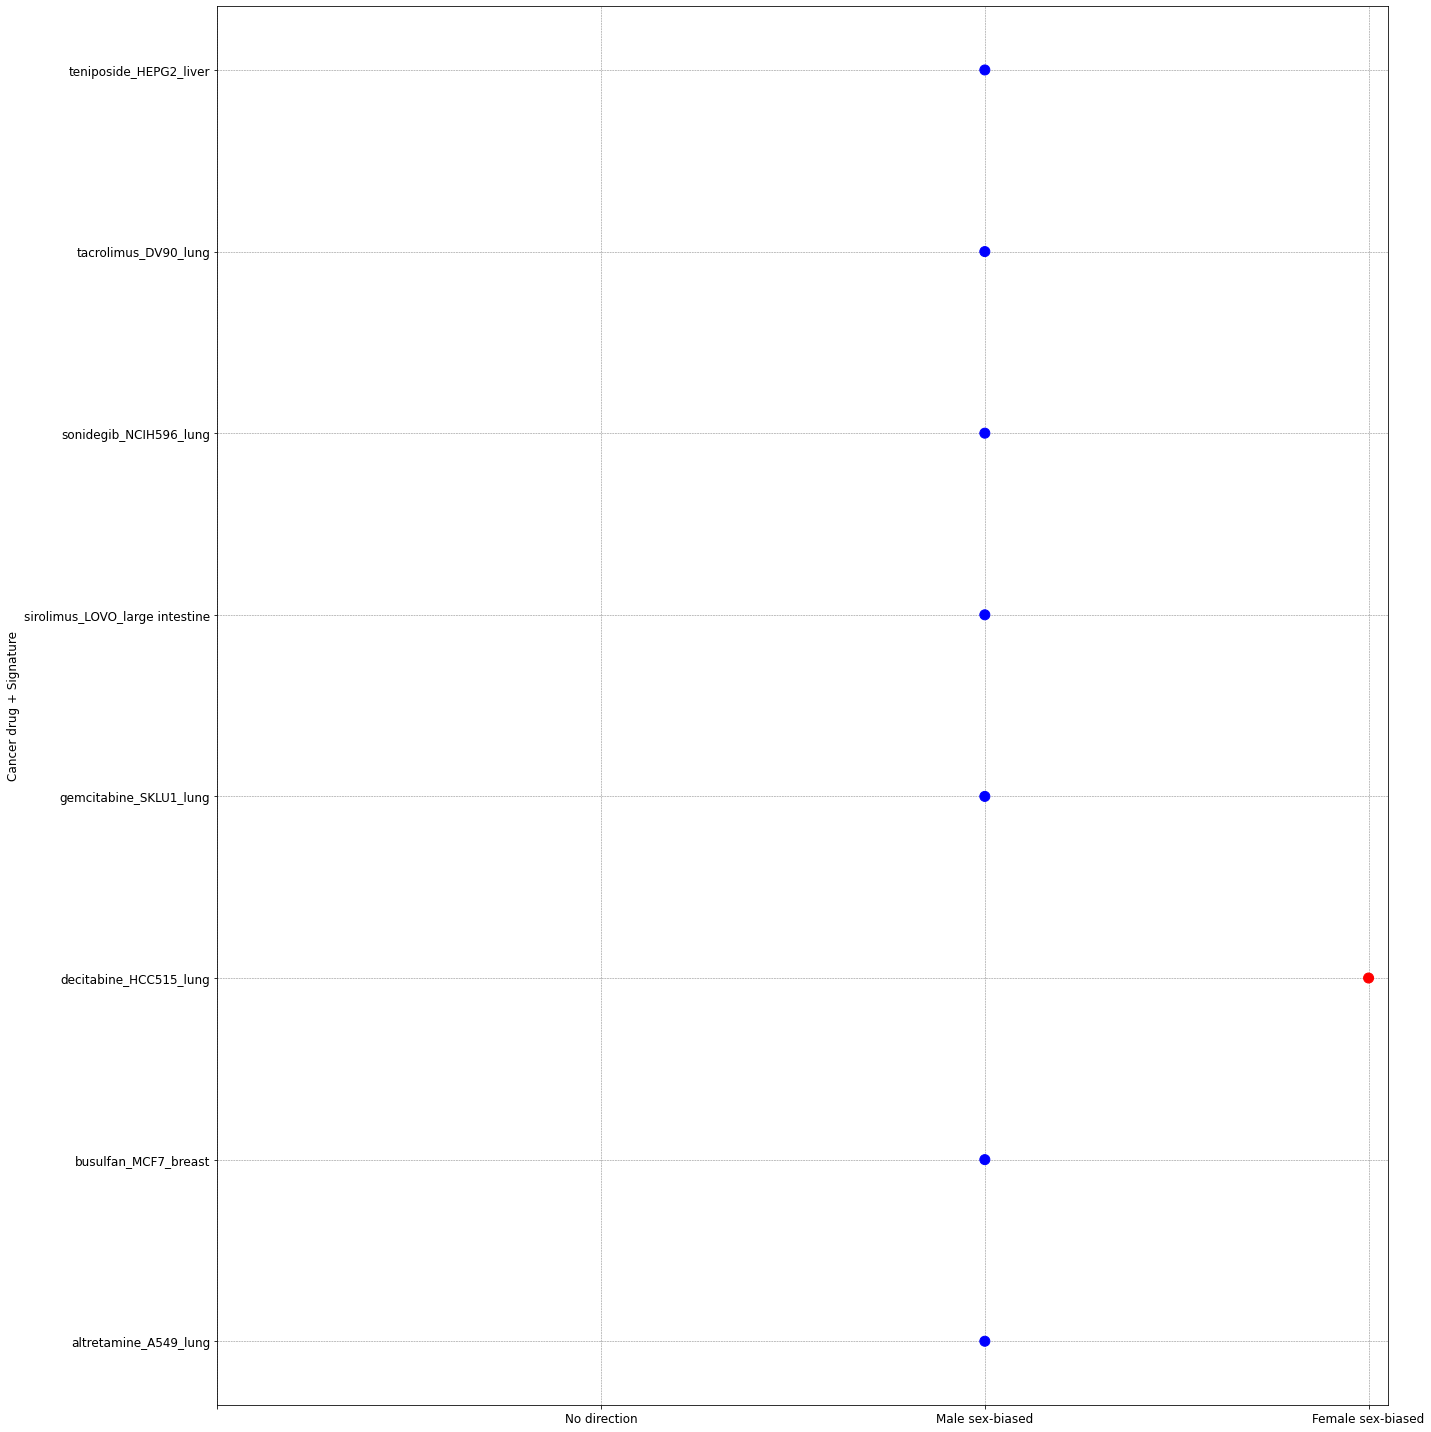

In [54]:
import matplotlib.pyplot as plt

# Define the colors for each category
category_colors = {
    1: 'green',            # No direction
    2: 'blue',           # Male sex-biased
    3: 'red'               # Female sex-biased
}

fig, ax = plt.subplots(figsize=(20, 20))

# Plot the scatter plot with colors based on category
scatter = plt.scatter(result_df['Gene-bias'], result_df['Signature_id_x'], c=result_df['Gene-bias'].map(category_colors), s=100, zorder=2)

# Set labels and x-axis ticks
#plt.xlabel('Sex-bias', fontsize=12)
plt.ylabel('Cancer drug + Signature', fontsize=12)
plt.xticks(range(4), [" ",'No direction', 'Male sex-biased', 'Female sex-biased'])

# Add grid
plt.grid(color='grey', linestyle='--', linewidth=0.5)

# Customize font for axes labels
plt.setp(ax.get_xticklabels(), fontsize=12, color="black", fontweight="normal")
plt.setp(ax.get_yticklabels(), fontsize=12, color="black", fontweight="normal")

# Save the plot
plt.tight_layout()
plt.savefig("./images_genes_overlap/enrichment_top30top5.svg")
plt.show()
